In [1]:
from cssmodel.simulation import *
import os.path as op
%matplotlib inline
import seaborn as sns
from joblib.parallel import Parallel, delayed
import seaborn as sns
from sklearn.utils.extmath import cartesian
sns.set_style('white')

/opt/conda/envs/neuro27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def _get_cov(sigma_ecc, sigma_size, roi, n=0.2):
    """
    Given sigma for eccentricity and size, get a covariance matrix by estimating
    the covariance from the slopes of the lines in Figure S2 from Kay et al., 2015.
    
    Parameters
    ----------
    sigma_ecc : float
        standard deviation for eccentricity
    sigma_size : float
        standard deviation for pRF size
    roi : str
        one of ['IOG', 'pFus', 'mFus']
    n : float
        power exponent
    
    Returns
    -------
    cov : array (2, 2)
        covariance between eccentricity and pRF size
    """
    cov = np.eye(2) * np.array([sigma_ecc ** 2, sigma_size ** 2])
    
    # let's try an approximation of the covariance based on figure S2
    fn = op.join('inputs', roi.lower() + '-slope.csv')
    slope = pd.read_csv(fn, header=None)
    slope.columns = ['eccentricity', 'size']
    # re-normalize size -- size in the paper is defined as sigma/sqrt(n)
    slope['size'] *= np.sqrt(n)
    
    # get what should be the first eigenvector
    e1 = slope.diff().as_matrix()[1]
    # norm it
    e1 /= np.sqrt(np.sum(e1**2))
    # this is the rotation matrix
    R = np.matrix([
     [e1[0], -e1[1]],
     [e1[1], e1[0]]
    ])
    # this is the rotated covariance matrix
    C = R*np.matrix(cov)*(R**-1)
    # impose the same variance as the original one
    C[0, 0] = cov[0, 0]
    C[1, 1] = cov[1, 1]

    return C

In [3]:
def get_mu_sigma_cov(roi, n=0.2):
    """
    Get the means for eccentricity, size, and their covariance based on the Figures in Kay et al., 2015
    
    Because we cannot reliably estimate the standard deviation from those figure, we assume an SD of 0.5 degrees
    """
    ecc_fn = op.join('inputs', 'kay2015_eccentricity.csv')
    size_fn = op.join('inputs', 'kay2015_size.csv')
    ecc_df = pd.read_csv(ecc_fn, header=None)
    ecc_df.columns = ['roi', 'eccentricity']
    size_df = pd.read_csv(size_fn, header=None)
    size_df.columns = ['roi', 'size']

    ecc_roi = ecc_df[[roi in c for c in ecc_df.roi]]
    size_roi = size_df[[roi in c for c in size_df.roi]]
    # the CIs in the figure represent 68% CIs of the median, approximately it is two standard deviations
    mu_ecc = ecc_roi['eccentricity'].iloc[0]
    sigma_ecc = 0.5
    # these are already normalized by sqrt(n); revert back to pixel size
    mu_size = size_roi['size'].iloc[0] * np.sqrt(n)
    sigma_size = 0.5 * np.sqrt(n)

    cov = _get_cov(sigma_ecc, sigma_size, roi, n=n)
    
    return mu_ecc, mu_size, cov

In [4]:
# make stimuli
stimuli = make_stimuli()

In [5]:
rois = ['IOG', 'mFus', 'pFus']
roi_values = {
    r: get_mu_sigma_cov(r) for r in rois
}

In [6]:
roi_values

{'IOG': (2.052173913043478,
  1.2278986003611563,
  matrix([[0.25      , 0.05461094],
          [0.05461094, 0.05      ]])),
 'mFus': (1.860869565217392,
  1.5225942644478336,
  matrix([[0.25      , 0.07677099],
          [0.07677099, 0.05      ]])),
 'pFus': (2.4521739130434783,
  1.6466766493264344,
  matrix([[0.25      , 0.05411797],
          [0.05411797, 0.05      ]]))}

In [7]:
def compute_varpse(pses, avg=0.5):
    return np.sum((pses - avg)**2, axis=1)

# First simulation -- keep the same number of units, change the ratio of those responsive to one or the other identity

In [8]:
n_voxels = 10
ratios = get_possible_ratios(n_voxels)[::-1]
print(ratios)

[1.         1.5        2.33333333 4.         9.        ]


In [9]:
comb_search = cartesian([rois, ratios])

In [10]:
n_exps = len(comb_search)
# create different master seeds for reproducibility
rng = np.random.RandomState(245)
master_seeds = [rng.randint(2**32) for _ in range(n_exps)]

In [13]:
out = Parallel(n_jobs=15, verbose=50)(
    delayed(simulate_bunch_experiments)
    (*roi_values[r], stimuli=stimuli, ratio_voxels=float(ratio), n_voxels=n_voxels, master_seed=seed, sigma_noise=0.1) 
    for (r, ratio), seed in zip(comb_search, master_seeds)
    )

[Parallel(n_jobs=15)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:    2.0s remaining:   12.7s
[Parallel(n_jobs=15)]: Done   3 out of  15 | elapsed:    2.0s remaining:    7.9s
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:    2.0s remaining:    5.4s
[Parallel(n_jobs=15)]: Done   5 out of  15 | elapsed:    2.0s remaining:    4.0s
[Parallel(n_jobs=15)]: Done   6 out of  15 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=15)]: Done   7 out of  15 | elapsed:    2.0s remaining:    2.3s
[Parallel(n_jobs=15)]: Done   8 out of  15 | elapsed:    2.0s remaining:    1.8s
[Parallel(n_jobs=15)]: Done   9 out of  15 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:    2.0s remaining:    1.0s
[Parallel(n_jobs=15)]: Done  11 out of  15 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=15)]: Done  12 out of  15 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=15)]: Done  13 out of  15 | el

In [14]:
dfs, pses, ts = zip(*out)
varpses = [compute_varpse(p) for p in pses]

In [15]:
df_varp = pd.DataFrame(varpses)
df_varp.index = pd.MultiIndex.from_tuples([roi_ratio for roi_ratio in comb_search], names=['roi', 'ratio'])
df_varp = df_varp.T
df_varp = pd.melt(df_varp)

In [16]:
df_varp.to_csv(op.join('outputs', 'sim_10vox_rois.csv'))

Text(0.5,0,u'Ratio of units selective to identity a')

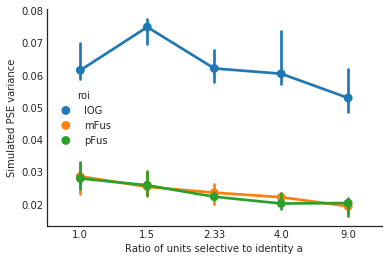

In [17]:
fig, ax = plt.subplots(1, 1)
sns.pointplot(x='ratio', y='value', hue='roi', 
              data=df_varp, 
              order=df_varp.ratio.unique(), ci=68, estimator=np.median, ax=ax)
sns.despine()
ax.set_ylabel('Simulated PSE variance')
ax.set_xlabel('Ratio of units selective to identity a')

# Second simulation,  growing number of units

In [18]:
# now let's try with a growing number of voxels
ratios = np.arange(1, 10)
n_voxels = 1 + ratios

In [19]:
comb_search = [(r, ratio, nvx) for r in rois for (ratio, nvx) in zip(ratios, n_voxels)]

In [20]:
comb_search[:10]

[('IOG', 1, 2),
 ('IOG', 2, 3),
 ('IOG', 3, 4),
 ('IOG', 4, 5),
 ('IOG', 5, 6),
 ('IOG', 6, 7),
 ('IOG', 7, 8),
 ('IOG', 8, 9),
 ('IOG', 9, 10),
 ('mFus', 1, 2)]

In [21]:
n_exps = len(comb_search)
# create different master seeds for reproducibility
rng = np.random.RandomState(245)
master_seeds = [rng.randint(2**32) for _ in range(n_exps)]

In [22]:
out2 = Parallel(n_jobs=15, verbose=5)(
    delayed(
        simulate_bunch_experiments)(*roi_values[r], stimuli=stimuli, ratio_voxels=ratio, 
                                    n_voxels=nvx, sigma_noise=0.1) 
    for r in rois for (ratio, nvx) in zip(ratios, n_voxels))

[Parallel(n_jobs=15)]: Done   4 out of  27 | elapsed:    1.7s remaining:    9.6s
[Parallel(n_jobs=15)]: Done  10 out of  27 | elapsed:    1.8s remaining:    3.0s
[Parallel(n_jobs=15)]: Done  16 out of  27 | elapsed:    3.2s remaining:    2.2s
[Parallel(n_jobs=15)]: Done  22 out of  27 | elapsed:    3.6s remaining:    0.8s
[Parallel(n_jobs=15)]: Done  27 out of  27 | elapsed:    3.8s finished


In [23]:
dfs, pses, ts = zip(*out2)
varpses = [compute_varpse(p) for p in pses]

In [24]:
df_varp = pd.DataFrame(varpses)
df_varp.index = pd.MultiIndex.from_tuples(
    [(ratio, r) for r in rois for (ratio, nvx) in zip(ratios, n_voxels)], names=['ratio', 'roi'])
# df_varp.index = pd.MultiIndex.from_tuples(combs.tolist(), names=['eccentricity', 'size', 'ratio'])
df_varp = df_varp.T
df_varp = pd.melt(df_varp)

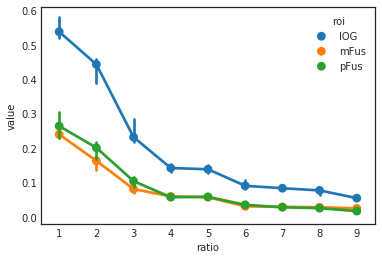

In [25]:
sns.pointplot(x='ratio', y='value', hue='roi', 
              data=df_varp, 
              order=df_varp.ratio.unique(), ci=68, estimator=np.median)

In [26]:
df_varp.to_csv(op.join('outputs', 'sim_varvox_rois.csv'))

# Third simulation, let's also modify the ratio of gains

In [27]:
# now let's try with a growing number of voxels
ratios = np.arange(1, 10)
n_voxels = 1 + ratios

In [28]:
ratio_nvox = [(r, ratio, nvx) for r in rois for (ratio, nvx) in zip(ratios, n_voxels)]

In [29]:
gains = np.arange(1, 4.25, 0.5)
gains

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [30]:
comb_search = [(r, ratio, nvx, g) for g in gains for (r, ratio, nvx) in ratio_nvox]

In [31]:
comb_search[:10]

[('IOG', 1, 2, 1.0),
 ('IOG', 2, 3, 1.0),
 ('IOG', 3, 4, 1.0),
 ('IOG', 4, 5, 1.0),
 ('IOG', 5, 6, 1.0),
 ('IOG', 6, 7, 1.0),
 ('IOG', 7, 8, 1.0),
 ('IOG', 8, 9, 1.0),
 ('IOG', 9, 10, 1.0),
 ('mFus', 1, 2, 1.0)]

In [32]:
n_exps = len(comb_search)
# create different master seeds for reproducibility
rng = np.random.RandomState(98698)
master_seeds = [rng.randint(2**32) for _ in range(n_exps)]

In [33]:
out3 = Parallel(n_jobs=15, verbose=5)(
    delayed(
        simulate_bunch_experiments)
    (*roi_values[r], stimuli=stimuli, ratio_voxels=ratio, n_sim=500,
     sigma_noise=0.1, ratio_gain=g, n_voxels=nvx, master_seed=seed) 
    for (r, ratio, nvx, g), seed in zip(comb_search, master_seeds))

[Parallel(n_jobs=15)]: Done  42 tasks      | elapsed:   27.7s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:  1.5min


[Parallel(n_jobs=15)]: Done 189 out of 189 | elapsed:  2.3min finished


In [34]:
dfs, pses, ts = zip(*out3)
varpses = [compute_varpse(p) for p in pses]

In [35]:
index_df = [(c[0], c[1], c[3]) for c in comb_search]
df_varp = pd.DataFrame(varpses)
df_varp.index = pd.MultiIndex.from_tuples(index_df, names=['roi', 'ratio', 'gain'])
# df_varp.index = pd.MultiIndex.from_tuples(combs.tolist(), names=['eccentricity', 'size', 'ratio'])
df_varp = df_varp.T
df_varp = pd.melt(df_varp)

In [36]:
d = df_varp[df_varp.roi == 'IOG']
#d = df_varp[df_varp.gain == 1.0]

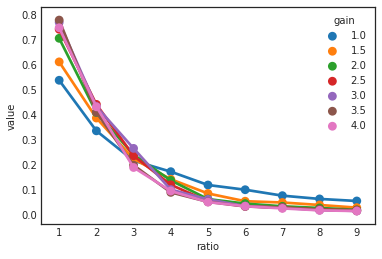

In [37]:
sns.pointplot(x='ratio', y='value', hue='gain', 
              data=d, 
              order=d.ratio.unique(), ci=False, estimator=np.median)

In [38]:
df_varp.to_csv(op.join('outputs', 'sim_varvox_7gain_rois.csv'))

# Plot example of PRFs covering more and more of the visual field

In [39]:
def plot_prfdensity(xs, ys, sigmas, n=0.2, res=100, ax=None):
    """
    Plot the coverage of a population of voxels

    Parameters
    ----------
    xs : array (n_voxels)
        centers
    ys : array (n_voxels)
        centers
    sigmas : array (n_voxels)
        std pRfs
    n : float
        power exponent
    res : int
        size of one of the sides
    ax : axis

    Returns
    -------
    ax : axis
    """
    x0 = y0 = res // 2
    xs = np.asarray(xs) + x0
    ys = np.asarray(ys) + y0

    f = np.zeros((res, res))
    for x, y, s in zip(xs, ys, sigmas):
        f += filledprf(x, y, s, n=n, res=res)
    f /= len(xs)

    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.imshow(f, aspect='equal', cmap='gray')
    ax.axhline(y0)
    ax.axvline(x0)
    return ax

In [40]:
def prfdensity(xs, ys, sigmas, n=0.2, res=100, ax=None):
    """
    Plot the coverage of a population of voxels

    Parameters
    ----------
    xs : array (n_voxels)
        centers
    ys : array (n_voxels)
        centers
    sigmas : array (n_voxels)
        std pRfs
    n : float
        power exponent
    res : int
        size of one of the sides
    ax : axis

    Returns
    -------
    ax : axis
    """
    x0 = y0 = res // 2
    xs = np.asarray(xs) + x0
    ys = np.asarray(ys) + y0

    f = np.zeros((res, res))
    for x, y, s in zip(xs, ys, sigmas):
        f += filledprf(x, y, s, n=n, res=res)
    f /= len(xs)

    return f

In [41]:
def plot_overlap_population(params, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    density_a = prfdensity(*params['a'])
    density_b = prfdensity(*params['b'])
    d = np.dstack((density_b, density_a, np.zeros((100, 100))))
    ax.imshow(d)
    return ax

In [42]:
from matplotlib.patches import Ellipse

In [43]:
def draw_stimuli(ax, scale=4., res=100):
    x0 = y0 = res // 2
    w = 4 * scale
    h = 4 * scale
    xpos = np.array((5, -5, -5, 5)) * scale + x0
    ypos = np.array((5, 5, -5, -5)) * scale + y0
    els = [
        Ellipse([x, y], width=w, height=h, facecolor='white', alpha=0.8) for x, y in zip(xpos, ypos)]
    for e in els:
        e.set_clip_box(ax.bbox)
        ax.add_artist(e)

In [44]:
def remove_ticks(ax):
    ax.set_xticklabels([])
    ax.set_yticklabels([])

In [45]:
def add_scale(ax, scale=4., res=100):
    y = res - scale*1
    x = res - scale*3
    ax.plot([x, x + scale], [y, y], 'white', solid_capstyle='projecting')
    # add text
    ax.text(x-1, y-2, '1$^\circ$ ', color='white', size=12, weight='heavy')

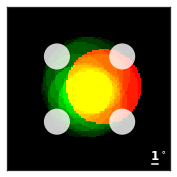

In [46]:
params, _ = get_params_pop(*roi_values['IOG'], n_voxels=10, ratio_voxels=9)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax = plot_overlap_population(params, ax=ax)
draw_stimuli(ax)
remove_ticks(ax)
add_scale(ax)

In [47]:
params['a'].shape

(3, 9)

Save figures showing example building up of coverage -- basically what we're modeling

In [ ]:
import os.path as op
import os

In [ ]:
img_dir = 'img'
if not op.exists(img_dir):
    os.makedirs(img_dir)

In [ ]:
rois

In [ ]:
# slowly build the final ratio
nratios = len(ratios)
rng = np.random.RandomState(42)
for roi in rois:
    params, _ = get_params_pop(*roi_values[roi], n_voxels=10, ratio_voxels=9, rng=rng)
    for ratio in ratios:
        params_ = params.copy()
        params_['a'] = params_['a'][:, :ratio]
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        ax = plot_overlap_population(params_, ax=ax)
        draw_stimuli(ax)
        remove_ticks(ax)
        add_scale(ax)
        fig.savefig(op.join(img_dir, '{0}_ratio{1:d}.png'.format(roi.lower(), ratio)), dpi=300, bbox_inches='tight')
        plt.close()